### Prediccion de episodios criticos de la calidad del aire en Temuco

### 1.1 Carga de datos

In [1]:
import pandas as pd
from functools import reduce

def cargar_y_limpiar(filepath, nombre_variable):
    df = pd.read_csv(filepath, sep=';', skipinitialspace=True, dtype=str, na_values=['', 'NaN', 'nan'])

    df.columns = [col.strip().strip(';') for col in df.columns]

    df.rename(columns={df.columns[0]: 'FECHA', df.columns[1]: 'HORA', df.columns[2]: nombre_variable}, inplace=True)

    df['HORA'] = df['HORA'].str.zfill(4)

    df['datetime'] = pd.to_datetime('20' + df['FECHA'] + df['HORA'], format='%Y%m%d%H%M', errors='coerce')

    df[nombre_variable] = df[nombre_variable].str.replace(',', '.', regex=False)
    df[nombre_variable] = pd.to_numeric(df[nombre_variable], errors='coerce')

    df_final = df[['datetime', nombre_variable]].copy()

    return df_final.sort_values('datetime').reset_index(drop=True)

archivos_vars = [
    ('Datos/Temuco/CO_Temuco_datos_180101_250101.csv',      'CO'),
    ('Datos/Temuco/HumRel_Temuco_datos_180101_250224.csv',   'HumRel'),
    ('Datos/Temuco/MP10_Temuco_datos_180101_250101.csv',     'MP10'),
    ('Datos/Temuco/MP25_Temuco_datos_180101_250101.csv',     'MP25'),
    ('Datos/Temuco/Precip_Temuco_datos_180101_250101.csv',   'Precip'),
    ('Datos/Temuco/Presion_Temuco_datos_180101_250101.csv',  'Presion'),
    ('Datos/Temuco/Temp_Temuco_datos_180101_250101.csv',     'Temp'),
    ('Datos/Temuco/VelViento_Temuco_datos_180101_250101.csv','VelViento'),
]


dfs = []
for archivo, var in archivos_vars:
    df_temp = cargar_y_limpiar(archivo, var)
    dfs.append(df_temp)

df_temuco = reduce(lambda left, right: pd.merge(left, right, on='datetime', how='outer'), dfs)

df_temuco['date'] = df_temuco['datetime'].dt.date
df_temuco['hour'] = df_temuco['datetime'].dt.hour

for var in ['CO', 'MP10', 'MP25']:
    valores_1am = df_temuco[df_temuco['hour'] == 0][['date', var]].set_index('date')
    df_temuco[var] = df_temuco.apply(
        lambda row: valores_1am.loc[row['date'], var] if pd.isna(row[var]) and row['date'] in valores_1am.index else row[var],
        axis=1
    )

df_temuco.drop(columns=['date', 'hour'], inplace=True)


df_temuco.head(10)

,datetime,CO,HumRel,MP10,MP25,Precip,Presion,Temp,VelViento
0,2018-01-01 00:00:00,0.23,NaN,14.0,3.0,NaN,NaN,NaN,NaN
1,2018-01-01 01:00:00,0.23,89.0,14.0,3.0,0.0,1012.0,9.3,0.4
2,2018-01-01 02:00:00,0.23,91.0,14.0,3.0,0.0,1011.0,8.5,0.5
3,2018-01-01 03:00:00,0.23,93.0,14.0,3.0,0.0,1011.0,7.9,0.3
4,2018-01-01 04:00:00,0.23,94.0,14.0,3.0,0.0,1011.0,7.4,NaN
5,2018-01-01 05:00:00,0.23,96.0,14.0,3.0,0.0,1011.0,6.7,0.2
6,2018-01-01 06:00:00,0.23,96.0,14.0,3.0,0.0,1012.0,9.0,0.1
7,2018-01-01 07:00:00,0.23,88.0,14.0,3.0,0.0,1012.0,11.7,0.5
8,2018-01-01 08:00:00,0.23,71.0,14.0,3.0,0.0,1012.0,13.5,1.2
9,2018-01-01 09:00:00,0.23,62.0,14.0,3.0,0.0,1012.0,15.2,1.8


In [2]:
df_temuco['VelViento'] = df_temuco['VelViento'].fillna(0)
df_temuco['CO'] = df_temuco['CO'].fillna(0)
df_temuco.isnull().sum()

datetime         0
CO               0
HumRel       16530
MP10          2832
MP25          2688
Precip        3223
Presion       2333
Temp          2397
VelViento        0
dtype: int64

In [3]:
df_temuco.shape

(62688, 9)

DESCRIPCION DE LOS DATOS

In [4]:
df_temuco['datetime'] = pd.to_datetime(df_temuco['datetime'])

data_n = df_temuco[df_temuco['datetime'] <= '2022-12-31']

data = data_n.dropna()
data.isnull().sum()
data.shape

(42046, 9)

### 1.2 Normalizacion

In [5]:
from sklearn.preprocessing import StandardScaler

data_numerica = data.select_dtypes(include='number')

scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_numerica)

df_scaled = pd.DataFrame(X_scaled, columns=data_numerica.columns)

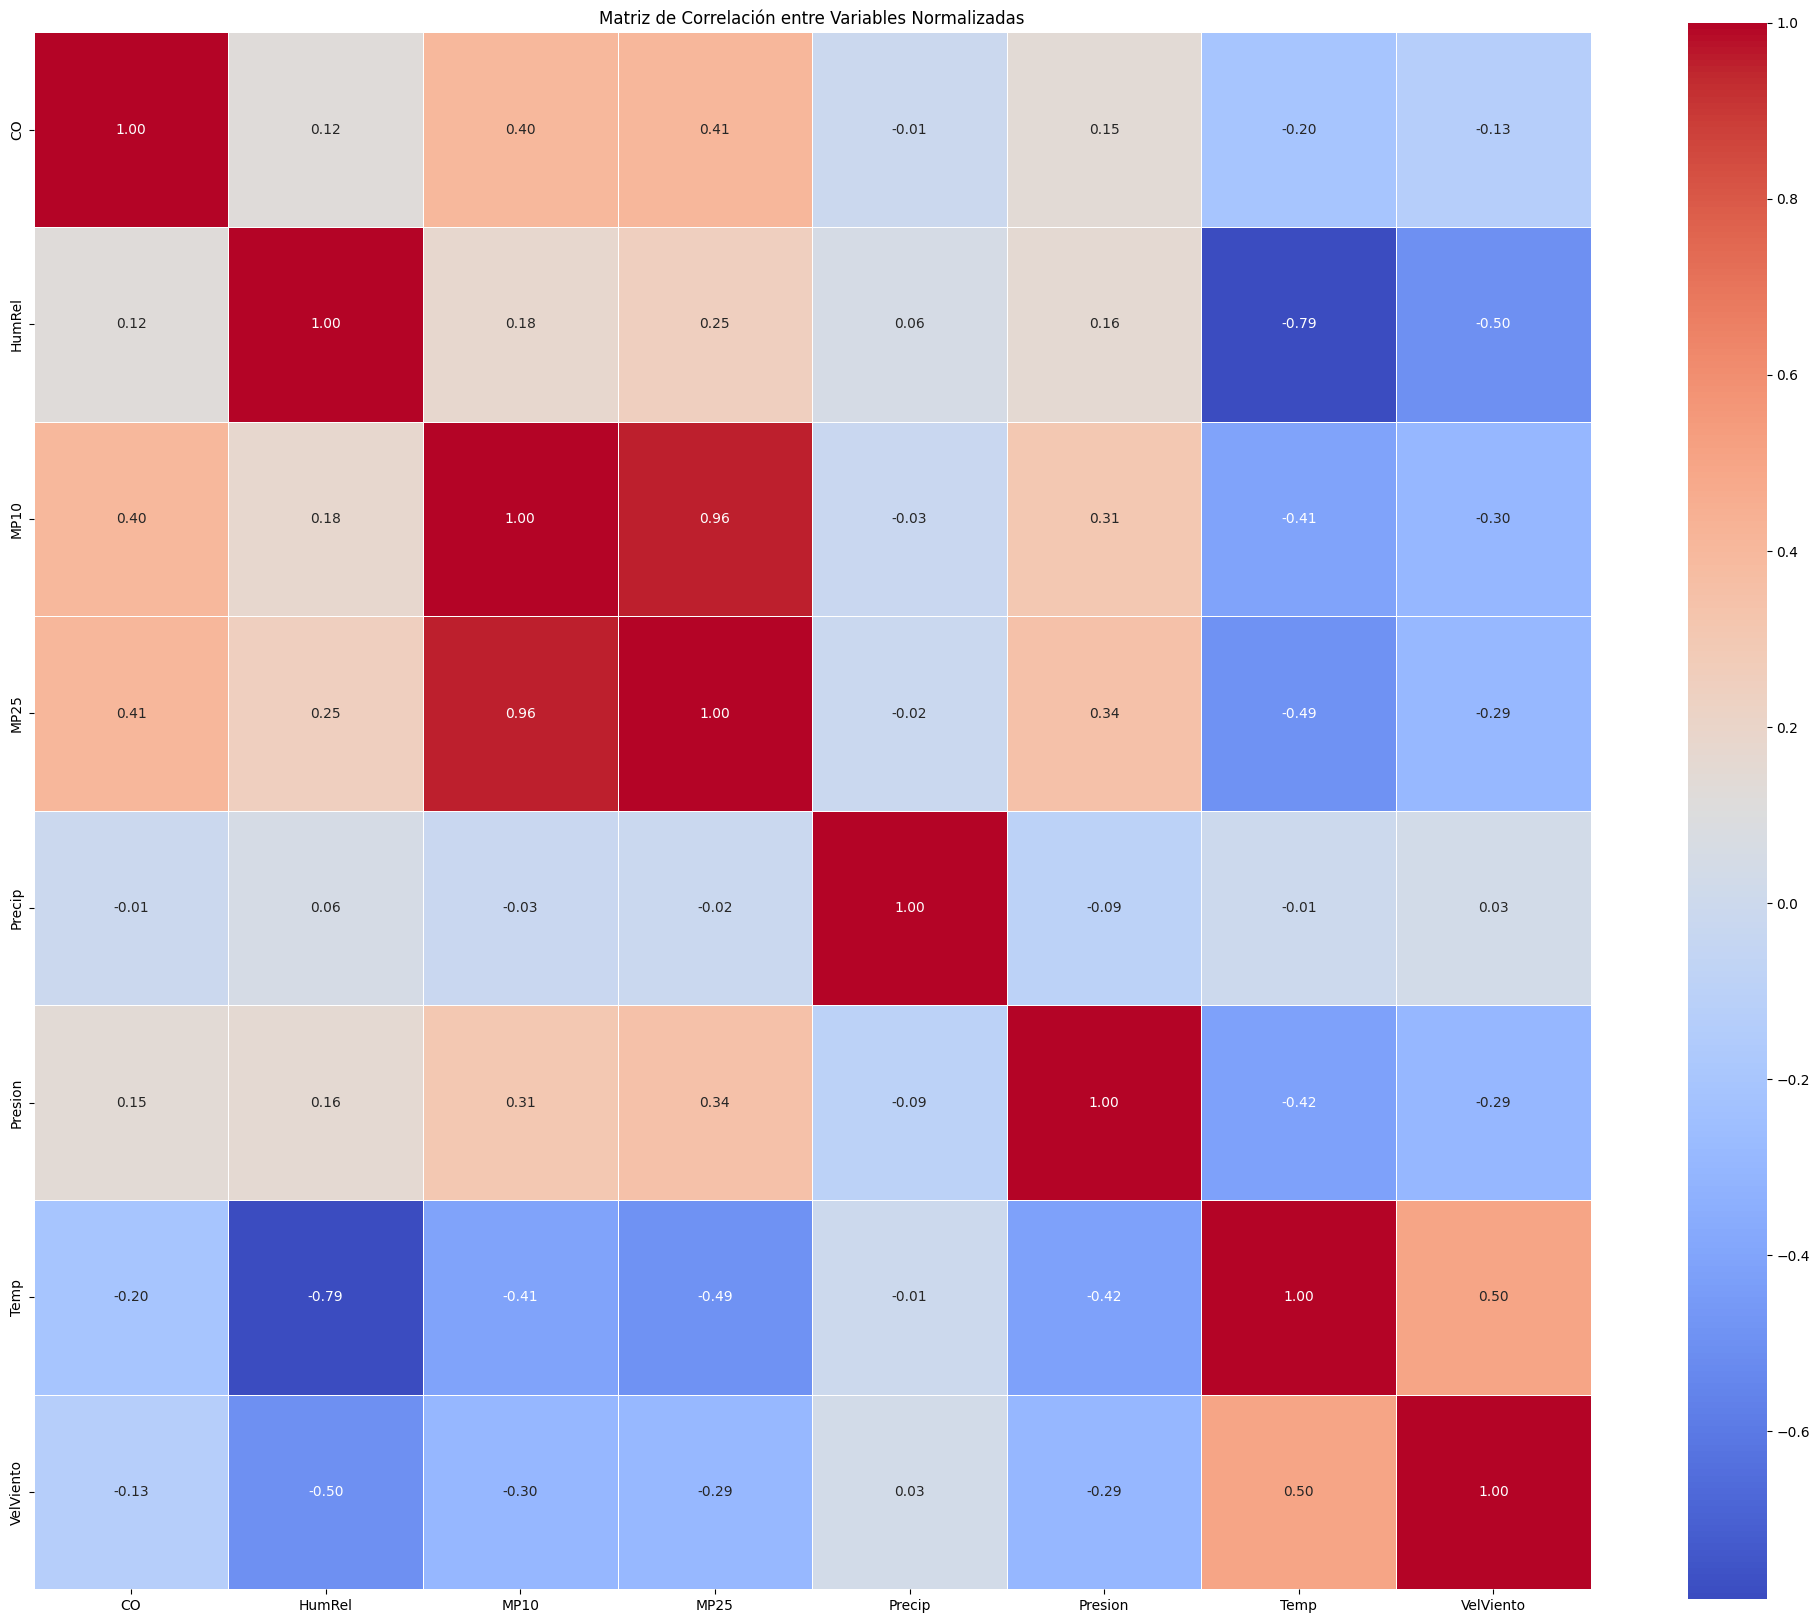

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

correlation_matrix = df_scaled.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title("Matriz de Correlación entre Variables Normalizadas")
plt.tight_layout()
plt.show()

Aplicamos PCA

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_scaled)

c:\Users\ianma\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
c:\Users\ianma\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\ianma\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


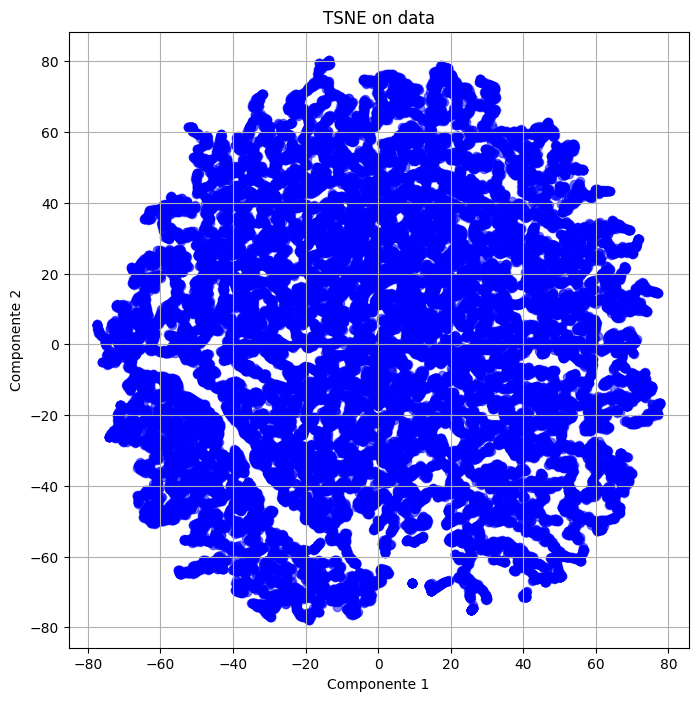

In [8]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity = 30, learning_rate=200, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_pca)

def plot_embedding(X, title):
    plt.figure(figsize=(8,8))
    plt.scatter(X[:, 0], X[:, 1], c='blue', marker='o', alpha=0.5)
    plt.title(title)
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    plt.grid(True)
    plt.show()

plot_embedding(X_tsne, 'TSNE on data')

In [9]:
import umap

reducer = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(X_pca)

plot_embedding(X_umap, 'UMAP on data')

c:\Users\ianma\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\ianma\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ianma\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


KeyboardInterrupt: 

DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=10)  

clusters_db = dbscan.fit_predict(X_pca)

df_scaled['cluster_dbscan'] = clusters_db


In [ ]:
import hdbscan

hdb = hdbscan.HDBSCAN(min_cluster_size=15)

clusters_hdb = hdb.fit_predict(X_pca)

df_scaled['cluster_hdbscan'] = clusters_hdb

c:\Users\cucho\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\cucho\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


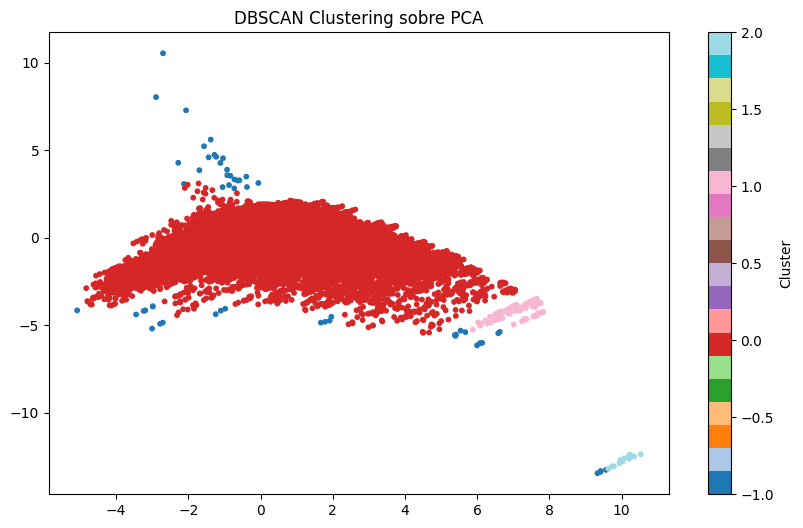

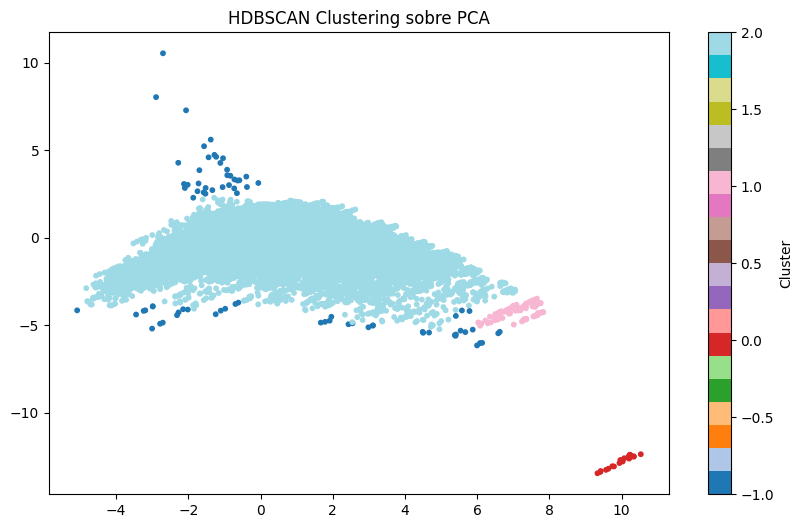

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_scaled['cluster_dbscan'], cmap='tab20', s=10)
plt.title('DBSCAN Clustering sobre PCA')
plt.colorbar(label='Cluster')
plt.show()

plt.figure(figsize=(10,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_scaled['cluster_hdbscan'], cmap='tab20', s=10)
plt.title('HDBSCAN Clustering sobre PCA')
plt.colorbar(label='Cluster')
plt.show()

KNN (en proceso para entrega 2)

In [14]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 1. Selecciondo las caract y excluyendo MP10, MP25 y CO
features = ['HumRel', 'Precip', 'Presion', 'Temp', 'VelViento']
X = data[features]
y = data[['MP10', 'MP25', 'CO']] # Son las variables objetivo

# Escalado
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 3. División en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=1
)

# Probando KNN multisalida
knn_reg = MultiOutputRegressor(KNeighborsRegressor(n_neighbors=5))
knn_reg.fit(X_train, y_train)
y_pred_knn = knn_reg.predict(X_test)

# Probando Modelo RandomForest multisalida
rf_reg = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=1))
rf_reg.fit(X_train, y_train)
y_pred_rf = rf_reg.predict(X_test)

# Evaluando...
for name, y_pred in [('KNN', y_pred_knn), ('RF', y_pred_rf)]:
    print(f"\n=== Resultados con {name} ===")
    for i, col in enumerate(y.columns):
        r2  = r2_score(y_test.iloc[:, i], y_pred[:, i])
        mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
        mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
        print(f"{col:>4} → R2: {r2:.3f}, MAE: {mae:.3f}, MSE: {mse:.3f}")



=== Resultados con KNN ===
MP10 → R2: 0.320, MAE: 16.566, MSE: 615.537
MP25 → R2: 0.368, MAE: 14.999, MSE: 539.302
  CO → R2: -0.007, MAE: 0.275, MSE: 0.797

=== Resultados con RF ===
MP10 → R2: 0.410, MAE: 15.644, MSE: 534.047
MP25 → R2: 0.457, MAE: 14.161, MSE: 462.960
  CO → R2: 0.094, MAE: 0.258, MSE: 0.718


In [23]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

base_rf = MultiOutputRegressor(
    RandomForestRegressor(random_state=1, n_jobs=-1, oob_score=True)
)

param_dist = {
    'estimator__n_estimators':      [250, 300, 350],
    'estimator__max_depth':         [18, 20, 22, 24],
    'estimator__max_features':      [0.2, 0.3, 0.4],
    'estimator__min_samples_split': [2, 3, 4],
    'estimator__min_samples_leaf':  [1, 2, 3],
}

tscv = TimeSeriesSplit(n_splits=5)

search = RandomizedSearchCV(
    base_rf,
    param_distributions=param_dist,
    n_iter=10,
    cv=tscv,
    scoring='r2',
    random_state=1,
    n_jobs=-1,
    verbose=2
)

search.fit(X_train, y_train)

best_params  = search.best_params_
best_model   = search.best_estimator_

oob_scores = {
    col: est.oob_score_
    for col, est in zip(y_train.columns, best_model.estimators_)
    if hasattr(est, "oob_score_")
}

y_pred = best_model.predict(X_test)

metrics = {}
for i, col in enumerate(y_train.columns):
    metrics[col] = {
        'r2' : r2_score(y_test.iloc[:, i], y_pred[:, i]),
        'mae': mean_absolute_error(y_test.iloc[:, i], y_pred[:, i]),
        'mse': mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
    }



Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [26]:
print("Mejores parámetros encontrados:", search.best_params_)
print("OOB Scores:", oob_scores)



Mejores parámetros encontrados: {'estimator__n_estimators': 350, 'estimator__min_samples_split': 2, 'estimator__min_samples_leaf': 1, 'estimator__max_features': 0.3, 'estimator__max_depth': 24}
OOB Scores: {'MP10': 0.42417239278509367, 'MP25': 0.4628306090957063, 'CO': 0.11144486358339434}
